# Network Science Data II (PHYS 7332) - Assignment 1

In [2]:
import networkx as nx
import random
import numpy as np
import pandas as pd
import re
import requests
from bs4 import BeautifulSoup
import random
import scipy.io as sio

## Question 2

In [127]:
# Question 2

def edge_exchange(G, t, max_u, node_attributes=False):
    """
    Perform a degree-preserving edge exchange algorithm on the graph G.
    
    The algorithm randomly selects pairs of edges and attempts to swap them while preserving 
    the node degrees and connectivity of the graph. The process continues until a specified number 
    of successful edge swaps (t) is reached or the maximum number of unsuccessful swap attempts (max_u) 
    is exceeded. The function also supports constraints based on node attributes.
    
    Parameters
    ----------
    G : networkx.Graph
        The input graph on which the edge exchange algorithm is applied. 
        The graph can be directed or undirected.
    
    t : int
        The target number of successful edge swaps to perform.
    
    max_u : int
        The maximum number of unsuccessful swap attempts allowed before terminating the algorithm.
    
    node_attributes : dict, optional (default=False)
        If provided, a dictionary of binary node attributes where the keys are node IDs and the values 
        are attributes. This ensures that node attributes are preserved along edges during edge swaps.
        If not provided, the algorithm does not consider node attributes.
    
    Returns
    -------
    G : networkx.Graph
        The graph after attempting the edge swaps, with the same node degrees but potentially 
        with different edge configurations.
    
    s : int
        The number of successful edge swaps performed.
    
    u : int
        The number of unsuccessful edge swap attempts.
    
    
    Warnings
    --------
    - A warning is printed if the maximum number of unsuccessful iterations is reached.
    - Unsuccessful swap attempts may occur when selected edges share nodes, the swapped edges already 
      exist, or the swap would break the graph's connectivity.
    
    Notes
    -----
    The edge swap maintains the degree distribution of the graph. An edge swap is deemed unsuccessful if:
    1. The edges share common nodes.
    2. The newly proposed edges already exist in the graph.
    3. The swap would change the number of connected components in the graph, thereby breaking connectivity.
    4. Node attributes are provided and the swap would result in a change in node attributes between the old and new edges.
    
    The algorithm terminates when either the specified number of successful swaps is reached or the number 
    of unsuccessful attempts exceeds the limit.
    """
    s = 0 # set successful counter to 0
    u = 0 # set unsuccessful counter to 0
    while s < t:
        if u >= max_u: # check if max number of unsuccessful iterations reached
            print("Maximum number of unsuccessful iterations reached")
            print("Terminating algorithm after", s, "successful and", u, "unsuccessful edge swaps")
            break
            
        edge_list = list(G.edges) # unpack nx.Graph into an edge list
        edge_1, edge_2 = random.sample(edge_list, 2) # choose two random edges from the edge list
        
        if edge_1[0] in edge_2 or edge_1[1] in edge_2: # check if any of the nodes are the same
            u = u + 1 # increment counter for unsucessful edge swap
            continue
            
        if (edge_1[0], edge_2[1]) in edge_list or (edge_1[1], edge_2[0]) in edge_list or (edge_2[1], edge_1[0]) in edge_list or (edge_2[0], edge_1[1]) in edge_list: # check if the proposed edges already exist
            u = u + 1 # increment counter for unsucessful edge swap
            continue

        # check if network would remain connected after edge swap
        F = G.copy()
        F.remove_edges_from([edge_1, edge_2])
        F.add_edges_from([(edge_1[0], edge_2[1]), (edge_1[1], edge_2[0])])
        
        if nx.number_connected_components(F) != nx.number_connected_components(G): # make sure n(connected components) stays the same
            u = u + 1 # increment counter for unsuccessful swap
            continue

        if node_attributes:
            edge_1_attr = [node_attributes[edge_1[0]], node_attributes[edge_1[1]]]
            edge_2_attr = [node_attributes[edge_2[0]], node_attributes[edge_2[1]]]
            new_edge_1_attr = [node_attributes[edge_1[0]], node_attributes[edge_2[1]]]
            new_edge_2_attr = [node_attributes[edge_1[1]], node_attributes[edge_2[0]]]
            if edge_1_attr != new_edge_1_attr or edge_2_attr != new_edge_2_attr:
                u = u + 1
                continue
            
        # if everything is okay, perform the edge swap
        G.remove_edge(edge_1[0], edge_1[1]) # remove edge 1 (i,j)
        G.remove_edge(edge_2[0], edge_2[1]) # remove edge 2 (u,v)
        G.add_edge(edge_1[0], edge_2[1]) # add edge (i,v)
        G.add_edge(edge_1[1], edge_2[0]) # add edge (j,u)
        
        s = s + 1 # increment counter for successful edge swap
        
    return(G, s, u)
    

## Question 3

In [21]:
# question 3 katz centrality

def calculate_katz_centrality(G, alpha, node = None):
    """
    Calculate the Katz centrality for each node in the graph G.
    
    Katz centrality is a measure of node influence that considers both the number of immediate neighbors and the influence of more distant nodes in the network. 
    It is computed by taking into account the sum of the weighted paths that connect nodes, where the influence of more distant nodes is exponentially attenuated 
    based on a damping parameter (alpha).
    
    Parameters
    ----------
    G : nx.Graph
        The input graph, which must be a NetworkX graph (either directed or undirected).
    
    alpha : float
        The attenuation factor, which controls the weight given to longer paths. 
        For the Katz centrality to converge, alpha must be less than the reciprocal of the largest eigenvalue of the adjacency matrix of G.
    
    node : object, optional (default = None)
        A specific node in the graph for which to return the Katz centrality. 
        If provided, the function returns the centrality of this node only. 
        If not provided, the function returns the Katz centrality for all nodes in the graph.
    
    Returns
    -------
    katz_centrality : list or float
        If `node` is not provided, returns a list of values corresponding to the normalized Katz centrality of each node.
        If `node` is specified, returns a single float representing the Katz centrality of the specified node.
    
    Raises
    ------
    TypeError
        If G is not a valid NetworkX graph.

    IndexError
        If specified node does not exist in G.
    
    ValueError
        If alpha is not smaller than the reciprocal of the largest eigenvalue of the adjacency matrix of G, 
        as Katz centrality does not converge in this case.
    
    Warnings
    --------
    - A warning is printed if the graph is not connected, as Katz centrality's interpretation is not well-defined for disconnected graphs.
    - A warning is printed if the largest eigenvalue of the adjacency matrix is zero, which indicates no connectivity in the graph.

    Notes
    -----
    The Katz centrality is calculated as:
    
        C_katz = (I - alpha * A)^-1 * 1
    
    where I is the identity matrix, A is the adjacency matrix, and 1 is a vector of ones.
    
    The centrality values are normalized by dividing each node's Katz centrality by the maximum value among all nodes.

    Examples
    --------
    >>> G = nx.path_graph(5)
    >>> calculate_katz_centrality(G, alpha=0.1)
    {0: 0.896, 1: 0.922, 2: 1.0, 3: 0.922, 4: 0.896}
    
    >>> calculate_katz_centrality(G, alpha=0.1, node=2)
    1.0
    """
    #warning = None
    if not isinstance(G, nx.Graph): # raise error if G is not nx.Graph
        raise TypeError("G must be a NetworkX graph")

    A = nx.adjacency_matrix(G).toarray() # convert G into adjacency matrix A
    eigvals = np.linalg.eigvals(A) # calculate the eigenvalues of A
    max_eigval = max(abs(val) for val in eigvals) # find the leading eigenvalue of A
    if max_eigval == 0: # check for unconnected graph
        raise Exception('Graph has no connectivity')
        
    if max_eigval >= 1/alpha: # check that alpha is with allowable range
        raise ValueError("Alpha must be less than the reciprocal of the leading eigenvalue of the adjacency matrix")
        
    if max_eigval != 0 and not nx.is_connected(G): # check that graph is connected (but not completely disconnected)
        raise Exception('Graph is disconnected. Interpretation of Katz centrality is not clear for disconnected graphs')
        # todo: calculate katz on disconnected subgraphs seperately

    I = np.eye(len(G)) # create the identity matrix of same size as A
    ones = np.array([1]*len(A)) # create vector of ones of same length as A
    katz_centrality = np.linalg.inv(I - alpha * A) @ ones # calculate katz centrality
    katz_normalized = katz_centrality/max(katz_centrality) # normalize by largest value
    if node:
        if node not in list(G.nodes()):
            raise IndexError("Node must be in graph G")
        katz_node = katz_normalized[node] # extract centrality of specified node
        return(katz_node)
    else:
        return(katz_normalized)


In [275]:
G1 = nx.random_lobster(50, 0.1, 0.05)
G2 = nx.erdos_renyi_graph(50, 0.1)
G3 = nx.barabasi_albert_graph(50, 2)
G4 = nx.Graph()
G4.add_nodes_from(range(50))
G5 = nx.algorithms.bipartite.random_graph(25, 25, p=0.2)

# define function to compare centrality function with the NetworkX implementation
def compare_nx_manual(G, function, alpha = 0.01):
    # Method 1: function to be tested
    warning = None
    try:
        katz_manual_norm = function(G, alpha)
    except Exception as e:
        sum_squared_diffs = np.nan
        corr = np.nan
        warning = str(e)
        return(sum_squared_diffs, corr, warning)    
    
    # Method 2: NetworkX function
    katz_nx = nx.katz_centrality(G, alpha = alpha, weight = 'weight') 
    
    # Convert nx result to numpy array for comparison
    katz_nx_array = np.array(list(katz_nx.values()))
    katz_nx_norm = katz_nx_array/max(katz_nx_array) # normalize nx result 

    # calculate the sum of squared differences between katz centrality of each node in each method
    squared_diffs = [abs((man - nx)**2) for man, nx in zip(katz_manual_norm, katz_nx_norm)] 
    sum_squared_diffs = sum(squared_diffs)

    # calculate the correlation between the results of the two katz centrality functions
    corr = np.corrcoef(katz_manual_norm, katz_nx_norm)[0, 1]
    return(sum_squared_diffs, corr, warning)

for graph in [G1, G2, G3, G4, G5]:
    a, b, c = compare_nx_manual(graph, calculate_katz_centrality)
    print(a, b, c)


2.8020697573582743e-15 0.9999999999999843 None
5.5109075783827525e-14 0.9999999999999604 None
3.0536324936696064e-13 0.9999999999999636 None
nan nan Graph has no connectivity
2.3017514308658328e-14 0.9999999999999645 None


In [270]:
def test_centrality_function(function):
    """
    Test a Katz centrality function by comparing its results to the NetworkX implementation across various graph types.
    
    This function tests a provided Katz centrality function against NetworkX's `katz_centrality` implementation. It computes 
    the Katz centrality for several graph types and compares the results by calculating the sum of squared differences and 
    the correlation between the two methods. It also generates Erdős-Rényi random graphs to compare performance across a 
    range of edge probabilities.
    
    Parameters
    ----------
    function : callable
        The Katz centrality function to be tested. It should accept a graph `G` and a decay parameter `alpha`, 
        and return the centrality values for all nodes, normalized by the largest value.

    Returns
    -------
    df1 : pandas.DataFrame
        A DataFrame containing the sum of squared differences and correlations between the two Katz centrality 
        implementations for a set of pre-defined graph types.
        Columns:
        - "graph": Name of the graph being tested.
        - "sum(squared diffs)": Sum of squared differences between Katz centrality values from the tested function 
          and NetworkX's implementation.
        - "correlations": Correlation coefficient between the Katz centrality values from both methods. NaN indicates 
          that the correlation coefficient couldn't be calculated which can happen if there is no variation in the difference 
          between the centrality measures.

    df2 : pandas.DataFrame
        A DataFrame containing the sum of squared differences and correlations between the two Katz centrality 
        implementations for Erdős-Rényi random graphs, with varying edge probabilities (p).
        Columns:
        - "p": Edge probability of the Erdős-Rényi graph.
        - "sum(squared diffs)": Sum of squared differences between Katz centrality values from the tested function 
          and NetworkX's implementation.
        - "correlations": Correlation coefficient between the Katz centrality values from both methods. NaN indicates 
          that the correlation coefficient couldn't be calculated which can happen if there is no variation in the difference 
          between the centrality measures.
        

    Notes
    -----
    The function tests the Katz centrality on the following graph types:
    - Complete graph
    - Adjacency matrix (not a graph object)
    - A fully disconnected graph
    - Star graph
    - Path graph
    - Cycle graph
    - Barbell graph
    - Full r-ary tree graph
    - Disconnected graph (union of two Erdős-Rényi graphs)
    - Bipartite graph
    - Watts-Strogatz small-world graph
    - Scale-free graph
    - Erdős-Rényi random graph
    - A graph with a very low leading eigenvalue
    - Weighted graph
    - Karate club graph
    - 2D lattice graph
    
    The function also generates Erdős-Rényi random graphs for 20 different edge probabilities between 0 and 1.
    
    Example
    -------
    >>> def my_katz_centrality_function(G, alpha):
    >>>     # User-defined Katz centrality calculation here
    >>>     pass
    >>> df1, df2 = test_centrality_function(my_katz_centrality_function)
    >>> print(df1)
    >>> print(df2)
    """

    # create test graphs
    complete_graph = nx.complete_graph(50)
    adjacency_matrix = nx.adjacency_matrix(complete_graph).toarray() 
    no_edges_graph = nx.Graph()
    no_edges_graph.add_nodes_from(range(50))
    star_graph = nx.star_graph(50)
    path_graph = nx.path_graph(50)
    cycle_graph = nx.cycle_graph(50)
    barbell_graph = nx.barbell_graph(30, 10)
    tree_graph = nx.full_rary_tree(3, 50)
    disconnected_graph = nx.disjoint_union(nx.erdos_renyi_graph(10, 0.1), nx.erdos_renyi_graph(40, 0.1))
    bipartite_graph = nx.algorithms.bipartite.random_graph(10, 40, p=0.2)
    watts_strogatz_graph = nx.watts_strogatz_graph(50, 4, 0.3)
    scale_free_graph = nx.barabasi_albert_graph(50, 2)
    er_graph = nx.erdos_renyi_graph(50, 0.4)
    low_eig_graph = er_graph.copy()
    for edge in low_eig_graph.edges:
        low_eig_graph.edges[edge]['weight'] = 6
    
    weighted = er_graph.copy()
    for (u, v) in er_graph.edges():
        weighted[u][v]['weight'] = random.uniform(0, 1)
    weighted_graph = weighted
    
    karate_club_graph = nx.karate_club_graph()
    lattice_graph = nx.grid_2d_graph(5, 10)

    test_graphs = [complete_graph, adjacency_matrix, no_edges_graph, star_graph, path_graph, cycle_graph, barbell_graph, tree_graph,
                  disconnected_graph, bipartite_graph, watts_strogatz_graph, scale_free_graph, er_graph, low_eig_graph,
                  weighted_graph, karate_club_graph, lattice_graph]
    names = ['complete_graph', 'adjacency_matrix', 'no_edges_graph', 'star_graph', 'path_graph', 'cycle_graph', 'barbell_graph', 'tree_graph',
              'disconnected_graph', 'bipartite_graph', 'watts_strogatz_graph', 'scale_free_graph', 'er_graph', 'low_eig_graph',
              'weighted_graph', 'karate_club_graph', 'lattice_graph']

    # define function to compare centrality function with the NetworkX implementation
    def compare_nx_manual(G, function, alpha = 0.01):
        # Method 1: function to be tested
        warning = None
        try:
            katz_manual_norm = function(G, alpha)
        except Exception as e:
            sum_squared_diffs = np.nan
            corr = np.nan
            warning = str(e)
            return(sum_squared_diffs, corr, warning)    
        # except TypeError as t:
        #     sum_squared_diffs = np.nan
        #     corr = np.nan
        #     warning = str(t)
        #     return(sum_squared_diffs, corr, warning)
        # except ValueError as v:
        #     sum_squared_diffs = np.nan
        #     corr = np.nan
        #     warning = str(v)
        #     return(sum_squared_diffs, corr, warning)
        
        # Method 2: NetworkX function
        katz_nx = nx.katz_centrality(G, alpha = alpha, weight = 'weight') 
        
        # Convert nx result to numpy array for comparison
        katz_nx_array = np.array(list(katz_nx.values()))
        katz_nx_norm = katz_nx_array/max(katz_nx_array) # normalize nx result 

        # calculate the sum of squared differences between katz centrality of each node in each method
        squared_diffs = [abs((man - nx)**2) for man, nx in zip(katz_manual_norm, katz_nx_norm)] 
        sum_squared_diffs = sum(squared_diffs)

        # calculate the correlation between the results of the two katz centrality functions
        corr = np.corrcoef(katz_manual_norm, katz_nx_norm)[0, 1]
        return(sum_squared_diffs, corr, warning)
        
    diffs1 = [0] * len(test_graphs)
    corrs1 = [0] * len(test_graphs)
    warnings1 = [0] * len(test_graphs)
    for i in range(len(test_graphs)):
        diffs1[i], corrs1[i], warnings1[i] = compare_nx_manual(test_graphs[i], function)
    data = {
        "graph": names,
        "sum(squared diffs)": diffs1,
        "correlations": corrs1,
        'warnings/errors': warnings1
    }
    df1 = pd.DataFrame(data)
    
    diffs2 = [0] * 20
    corrs2 = [0] * 20
    warnings2 = [0] * 20
    for i in range(20):
        G = nx.erdos_renyi_graph(50, np.linspace(0.0,1,20)[i])
        diffs2[i], corrs2[i], warnings2[i] = compare_nx_manual(G, function)
    data = {
        "p": np.linspace(0.0,1,20),
        "sum(squared diffs)": diffs2,
        "correlations": corrs2,
        'warnings/errors': warnings2
    }
    df2 = pd.DataFrame(data)
    return(df1, df2)

In [271]:
table1, table2 = test_centrality_function(calculate_katz_centrality)

In [272]:
print(table1)

                   graph  sum(squared diffs)  correlations  \
0         complete_graph        7.507737e-29           NaN   
1       adjacency_matrix                 NaN           NaN   
2         no_edges_graph                 NaN           NaN   
3             star_graph        8.356995e-30           1.0   
4             path_graph        1.338687e-17           1.0   
5            cycle_graph        8.085824e-30           NaN   
6          barbell_graph        5.303088e-14           1.0   
7             tree_graph        2.062573e-14           1.0   
8     disconnected_graph                 NaN           NaN   
9        bipartite_graph                 NaN           NaN   
10  watts_strogatz_graph        2.400564e-15           1.0   
11      scale_free_graph        1.329687e-13           1.0   
12              er_graph        8.072162e-14           1.0   
13         low_eig_graph                 NaN           NaN   
14        weighted_graph        3.085431e-15           1.0   
15     k

In [185]:
print(table2)

           p  sum(squared diffs)  correlations  \
0   0.000000        0.000000e+00           NaN   
1   0.052632        1.004685e-15           1.0   
2   0.105263        3.020214e-15           1.0   
3   0.157895        1.081051e-14           1.0   
4   0.210526        6.046760e-15           1.0   
5   0.263158        2.525033e-13           1.0   
6   0.315789        5.911237e-14           1.0   
7   0.368421        1.192980e-13           1.0   
8   0.421053        9.340043e-15           1.0   
9   0.473684        5.171587e-14           1.0   
10  0.526316        3.565361e-14           1.0   
11  0.578947        5.725744e-14           1.0   
12  0.631579        2.582496e-14           1.0   
13  0.684211        3.313598e-14           1.0   
14  0.736842        3.726316e-14           1.0   
15  0.789474        4.565391e-14           1.0   
16  0.842105        9.319345e-15           1.0   
17  0.894737        4.553715e-15           1.0   
18  0.947368        2.385734e-15           1.0   


## Question 4

In [ ]:
catalog_html = requests.get('https://catalog.northeastern.edu/course-descriptions/').text
soup = BeautifulSoup(catalog_html)
soup_alpha_div = soup.find('div', id="atozindex")
department_hrefs = []
for ul in soup_alpha_div.find_all('ul'):
    for li in ul.find_all('li'):
        department_hrefs.append(li.a.get('href'))

In [104]:
edge_list = []
prereqs_per_course = []
dep_acronyms = []
total_prereqs = []
num_courses = []

for href in department_hrefs:
    full_url = 'https://catalog.northeastern.edu' + href
    dept_html = requests.get(full_url).text
    soup = BeautifulSoup(dept_html)
    courseblocks = soup.find_all('div', class_ = 'courseblock')
    number_of_courses = len(courseblocks) # count total number of courses
    num_prerequisites = []
    for block in courseblocks:
        title = str(block.find('strong')).replace('<strong>', '').split('.')[0].replace('\xa0',' ') # extracts course title
        if 'Prerequisite' in str(block.find('p', class_ = 'courseblockextra noindent')): # check if there is a prerequisites block
            thing = block.find('p', class_ = 'courseblockextra noindent').text.replace('\xa0', ' ') # extracts prerequisite text and removes weird characters
            dep_acronym = href.strip('/').rsplit('/')[-1].upper() # extract department acronym from href
            pattern = r'\b[A-Z]{2,4} \d{4}\b' # find courses in prerequisites (2-4 capital letters followed by a space and four numbers)
            prereqs = re.findall(pattern, thing)
            num_prerequisites.append(len(prereqs)) # count number of prerequisites
            
            for prereq in prereqs:
                edge_list.append([prereq, title]) # add course a prerequisite to the edge list
        else:
            num_prerequisites.append(0) # in case there are no prerequisites
    dep_acronyms.append(dep_acronym)
    prereqs_per_course.append(np.mean(num_prerequisites))
    total_prereqs.append(sum(num_prerequisites))
    num_courses.append(number_of_courses)

/courses/PHYS7332.202510/shared/phys7332-env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/courses/PHYS7332.202510/shared/phys7332-env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [105]:
df = pd.DataFrame({
        "departments": dep_acronyms,
        "prereqs_per_course": prereqs_per_course,
        "total_prereqs": total_prereqs,
        "total_courses": num_courses
    })
print(df)


    departments  prereqs_per_course  total_prereqs  total_courses
0          ACCT            0.790323             49             62
1           ACC            0.736842             14             19
2           AVM            0.666667             10             15
3           AVM            0.000000              0              5
4          AFCS            1.326087             61             46
..          ...                 ...            ...            ...
224         TCC            0.227273              5             22
225        TELR            0.272727              3             11
226        TELE            0.565217             13             23
227        THTR            0.260870             18             69
228        WMNS            1.261905             53             42

[229 rows x 4 columns]


In [106]:
df.loc[df['prereqs_per_course'].idxmax()]


departments               ENGL
prereqs_per_course    3.647541
total_prereqs              445
total_courses              122
Name: 85, dtype: object

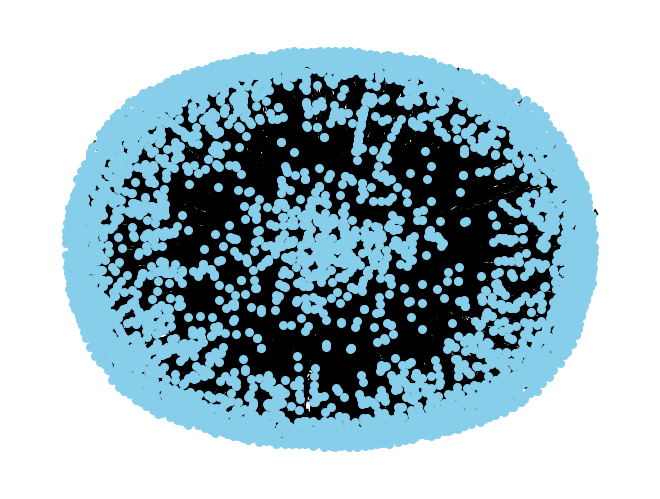

In [108]:
prereq_graph = nx.DiGraph()
prereq_graph.add_edges_from(edge_list)
# nx.draw(prereq_graph, with_labels=False, node_color="skyblue", node_size=30, font_size=9, font_weight="bold", arrows=True)


In [111]:
cycles = list(nx.simple_cycles(prereq_graph))
print(cycles)

[['SPNS 2102'], ['SPNS 3101'], ['SPNS 3102'], ['SPNS 2101'], ['SPNS 1101'], ['SPNS 1102'], ['SPNS 3603', 'SPNS 3602']]


In [115]:
test_graph = prereq_graph.copy()
edges_to_remove = [['SPNS 2102', 'SPNS 2102'],
                  ['SPNS 3101', 'SPNS 3101'],
                  ['SPNS 3102', 'SPNS 3102'],
                  ['SPNS 2101', 'SPNS 2101'],
                  ['SPNS 1101', 'SPNS 1101'],
                  ['SPNS 1102', 'SPNS 1102'],
                  ['SPNS 3603', 'SPNS 3602']]
test_graph.remove_edges_from(edges_to_remove)
nx.dag_longest_path(test_graph)

['BIOL 1107',
 'BIOL 1113',
 'PHSC 2301',
 'PHSC 2303',
 'HSCI 1105',
 'NRSG 2220',
 'NRSG 3323',
 'NRSG 3320',
 'NRSG 3420',
 'NRSG 4502',
 'NRSG 4995']

## Question 5

In [3]:
# https://networkrepository.com/bio-dmela.php
mtx_data = sio.mmread('data/bio-dmela.mtx') 

dense_array = mtx_data.toarray()

In [4]:
G = nx.from_numpy_array(dense_array)
G_ppi = G.copy()

In [5]:
print(G.number_of_nodes())
print(G.number_of_edges())


7393
25569


In [6]:
degree_sequence = [d for n, d in G_ppi.degree()]

In [26]:
config_G = nx.configuration_model(degree_sequence)

In [78]:
# this takes a hot minute, hence I've saved the output as ppi_randomized.pickle
randomized_G, s, u = edge_exchange(G, 25000, 1000)

True

In [8]:
import pickle
# # Save the graph to a file
# with open('ppi_randomized.pickle', 'wb') as f:
#     pickle.dump(randomized_G, f)

# Load the graph from the file
with open('data/ppi_randomized.pickle', 'rb') as f:
    randomized_G = pickle.load(f)

In [25]:
def degree_distribution(G, number_of_bins=15, log_binning=True, density=True, directed=False):
    """
    Given a degree sequence, return the y values (probability) and the
    x values (support) of a degree distribution that you're going to plot.
    
    Parameters
    ----------
    G (nx.Graph):
        the network whose degree distribution to calculate

    number_of_bins (int):
        length of output vectors
    
    log_binning (bool):
        if you are plotting on a log-log axis, then this is useful
    
    density (bool):
        whether to return counts or probability density (default: True)
        Note: probability densities integrate to 1 but do not sum to 1. 

    directed (bool or str):
        if False, this assumes the network is undirected. Otherwise, the
        function requires an 'in' or 'out' as input, which will create the 
        in- or out-degree distributions, respectively.
        
    Returns
    -------
    bins_out, probs (np.ndarray):
        probability density if density=True node counts if density=False; binned edges
    
    """

    # Step 0: Do we want the directed or undirected degree distribution?
    if directed:
        if directed=='in':
            k = list(dict(G.in_degree()).values()) # get the in degree of each node
        elif directed=='out':
            k = list(dict(G.out_degree()).values()) # get the out degree of each node
        else:
            out_error = "Help! if directed!=False, the input needs to be either 'in' or 'out'"
            print(out_error)
            # Question: Is this the correct way to raise an error message in Python?
            #           See "raise" function...
            return out_error
    else:
        k = list(dict(G.degree()).values()) # get the degree of each node


    # Step 1: We will first need to define the support of our distribution
    kmax = np.max(k)    # get the maximum degree
    kmin = 0            # let's assume kmin must be 0


    # Step 2: Then we'll need to construct bins
    if log_binning:
        # array of bin edges including rightmost and leftmost
        bins = np.logspace(0, np.log10(kmax+1), number_of_bins+1)
    else:
        bins = np.linspace(0, kmax+1, num=number_of_bins+1)


    # Step 3: Then we can compute the histogram using numpy
    probs, _ = np.histogram(k, bins, density=density)


    # Step 4: Return not the "bins" but the midpoint between adjacent bin
    #         values. This is a better way to plot the distribution.
    bins_out = bins[1:] - np.diff(bins)/2.0
    
    return bins_out, probs
    
def centrality_distribution(katz, number_of_bins=15, log_binning=True, density=True):

    # Step 1: We will first need to define the support of our distribution
    katz_max = np.max(katz)    
    katz_min = np.min(katz)          

    # Step 2: Then we'll need to construct bins
    if log_binning:
        # array of bin edges including rightmost and leftmost
        bins = np.logspace(np.log10(katz_min), np.log10(katz_max+1), number_of_bins+1)
    else:
        bins = np.linspace(katz_min, katz_max+0.0001, num=number_of_bins+1)

    # Step 3: Then we can compute the histogram using numpy
    probs, _ = np.histogram(katz, bins, density=density)

    # Step 4: Return not the "bins" but the midpoint between adjacent bin
    #         values. This is a better way to plot the distribution.
    bins_out = bins[1:] - np.diff(bins)/2.0
    
    return bins_out, probs
    
def calculate_katz_centrality(G, alpha):
    """

    """
    A = nx.adjacency_matrix(G).toarray() # convert G into adjacency matrix
    # A = dense_array
    
    if not isinstance(G, nx.Graph):
        print("Error: G must be a NetworkX graph")
        
    # if node not in list(G.nodes()):
    #     print("Error: node must be in graph G")
        
    eigvals = np.linalg.eigvals(A)
    max_eigval = max(abs(val) for val in eigvals)
    if alpha >= 1/max_eigval:
        print("Error: alpha must be less than the reciprocal of the leading eigenvalue of the adjacency matrix")
        
    if not nx.is_connected(G):
        print('Warning: interpretation of Katz centrality is not clear for disconnected graphs')
        # todo: calculate katz on disconnected subgraphs seperately
    
    I = np.eye(len(G)) # create the identity matrix of same size as A
    ones = np.array([1]*len(A)) # create vector of ones of same length as A
    katz_centrality = np.linalg.inv(I - alpha * A) @ ones # calculate katz centrality
    katz_normalized = katz_centrality/max(katz_centrality) # normalize by largest value
    #katz_node = katz_normalized[node] # extract centrality of specified node
    return(katz_normalized)
    
def average_shortest_path_length_per_node(G):
    """
    Compute the average shortest path length for each node in the graph G.
    
    :param G: NetworkX graph (can be directed or undirected)
    :return: Dictionary where keys are nodes and values are the average shortest path lengths.
    """
    avg_shortest_paths = {}
    
    # Compute shortest path lengths from each node to every other node
    for node in G.nodes():
        shortest_paths = nx.shortest_path_length(G, source=node)  # Dictionary of shortest paths from `node`
        
        # Compute the average shortest path length for the current node
        total_length = sum(shortest_paths.values())  # Sum of shortest paths
        num_nodes = len(shortest_paths)  # Number of reachable nodes
        
        avg_shortest_paths[node] = total_length / (num_nodes - 1)  # Exclude the node itself from the average
    
    return avg_shortest_paths

shortest_paths_ppi = average_shortest_path_length_per_node(G_ppi)
shortest_paths_rand = average_shortest_path_length_per_node(randomized_G)

In [11]:
ppi_degbins, ppi_pk = degree_distribution(G_ppi)
rand_degbins, rand_pk = degree_distribution(randomized_G)
config_degbins, config_pk = degree_distribution(config_G)

In [24]:
katz_ppi = calculate_katz_centrality(G_ppi, 0.02)
katz_randomized = calculate_katz_centrality(randomized_G, 0.02)
katz_config = calculate_katz_centrality(config_G, 0.02)

In [14]:
ppi_katzbins, ppi_pkatz = centrality_distribution(katz_ppi, number_of_bins=35, log_binning = True)
rand_katzbins, rand_pkatz = centrality_distribution(katz_randomized, number_of_bins=35, log_binning = True)
config_katzbins, config_pkatz = centrality_distribution(katz_config, number_of_bins=35, log_binning = True)

In [18]:
ppi_dbins, ppi_pd = centrality_distribution(list(shortest_paths_ppi.values()), number_of_bins=35, log_binning = False)
rand_dbins, rand_pd = centrality_distribution(list(shortest_paths_rand.values()), number_of_bins=35, log_binning = False)

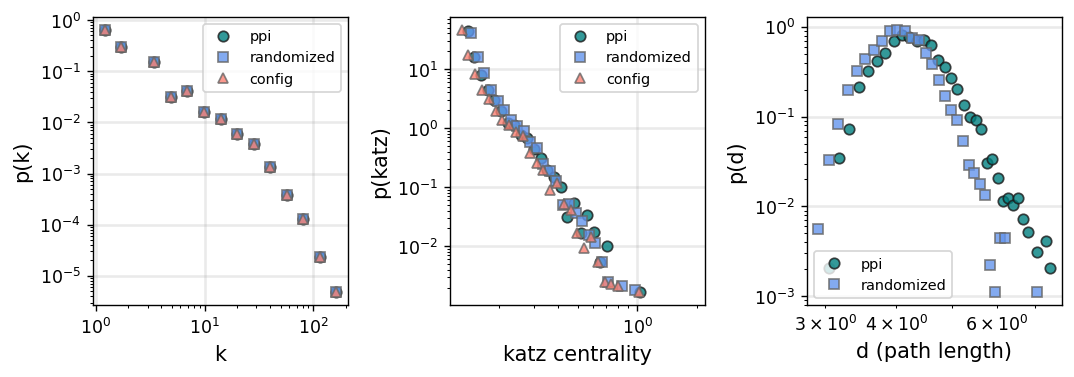

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(10,3),dpi=125)
plt.subplots_adjust(wspace=0.40, hspace=0.30)

ax[0].loglog(ppi_degbins, ppi_pk,'o', label = 'ppi', color='teal', alpha=0.8, mec='.1')
ax[0].loglog(rand_degbins, rand_pk,'s', label = 'randomized', color='cornflowerblue', alpha=0.8, mec='.4')
ax[0].loglog(config_degbins, config_pk,'^', label = 'config', color='salmon', alpha=0.8, mec='.4')

ax[1].loglog(ppi_katzbins, ppi_pkatz,'o', label = 'ppi', color='teal', alpha=0.8, mec='.1')
ax[1].loglog(rand_katzbins, rand_pkatz,'s', label = 'randomized', color='cornflowerblue', alpha=0.8, mec='.4')
ax[1].loglog(config_katzbins, config_pkatz,'^', label = 'config', color='salmon', alpha=0.8, mec='.4')

ax[2].loglog(ppi_dbins, ppi_pd,'o', label = 'ppi', color='teal', alpha=0.8, mec='.1')
ax[2].loglog(rand_dbins, rand_pd,'s', label = 'randomized', color='cornflowerblue', alpha=0.8, mec='.4')

ax[0].legend(fontsize='small')
ax[0].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[0].set_xlabel('k',fontsize='large')
ax[0].set_ylabel('p(k)',fontsize='large')

ax[1].legend(fontsize='small')
ax[1].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[1].set_xlabel('katz centrality',fontsize='large')
ax[1].set_ylabel('p(katz)',fontsize='large')

ax[2].legend(fontsize='small')
ax[2].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[2].set_xlabel('d (path length)',fontsize='large')
ax[2].set_ylabel('p(d)',fontsize='large')

plt.savefig('figs/compare_distributions.pdf', bbox_inches='tight')
